In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

In [2]:
# Check if the version is TensorFlow 2.x
if tf.__version__.startswith('2'):
    physical_devices = tf.config.list_physical_devices('GPU')
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [3]:
def get_file_names_in_directory(directory_path):
    if not os.path.isdir(directory_path):
        print(f"{directory_path} n'est pas un dossier valide.")
        return []

    return os.listdir(directory_path)

In [4]:
def load_data(directory):
    images = []
    labels = []
    label_dict = {}  # To map class names to unique labels
    current_label = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        label_dict[class_name] = current_label
        current_label += 1

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            if os.path.isfile(image_path):
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                if image is not None:
                    images.append(image)
                    labels.append(label_dict[class_name])

    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels


In [5]:
def shuffle_data(images, labels):
    num_samples = len(images)
    shuffled_indices = np.random.permutation(num_samples)

    shuffled_images = images[shuffled_indices]
    shuffled_labels = labels[shuffled_indices]

    return shuffled_images, shuffled_labels

In [6]:
def plot_images(images, labels, nb_rows=6, nb_cols=6, categories=None):
    nb = nb_cols * nb_rows
    total_images = len(images)
    
    categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    for i in range(min(nb, total_images)):
        plt.subplot(nb_rows, nb_cols, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"{labels[i]} : {categories[labels[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
def count_elements(array):
    unique_elements, counts = np.unique(array, return_counts=True)
    element_counts = dict(zip(unique_elements, counts))
    return element_counts

In [8]:
directory = "images"

categories = get_file_names_in_directory(os.path.join(directory, "train"))

train_images, train_labels = load_data(os.path.join(directory, "train"))
val_images, val_labels = load_data(os.path.join(directory, "validation"))

In [9]:
print(f"Categories : {categories}")

Categories : ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
print(f"Train data shape : {(train_images.shape, train_labels.shape)},\
    \nValidation data shape : {(val_images.shape, val_labels.shape)}")

Train data shape : ((28821, 48, 48), (28821,)),    
Validation data shape : ((7066, 48, 48), (7066,))


In [11]:
train_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

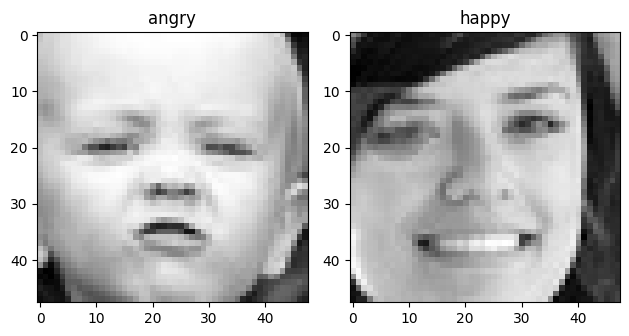

In [12]:
idx = np.random.randint(0, len(val_labels))
plt.subplot(1, 2, 1)
plt.imshow(train_images[idx], cmap="gray")
plt.title(f"{categories[train_labels[idx]]}")

plt.subplot(1, 2, 2)
plt.imshow(val_images[idx], cmap="gray")
plt.title(f"{categories[val_labels[idx]]}")

plt.tight_layout()
plt.show()

In [13]:
np.random.seed(0)
train_shuffled_images, train_shuffled_labels = shuffle_data(train_images, train_labels)
val_shuffled_images, val_shuffled_labels = shuffle_data(val_images, val_labels)

sum(train_shuffled_labels == train_labels), sum(val_shuffled_labels == val_labels)

(5024, 1208)

In [14]:
train_shuffled_images.shape, val_shuffled_images.shape

((28821, 48, 48), (7066, 48, 48))

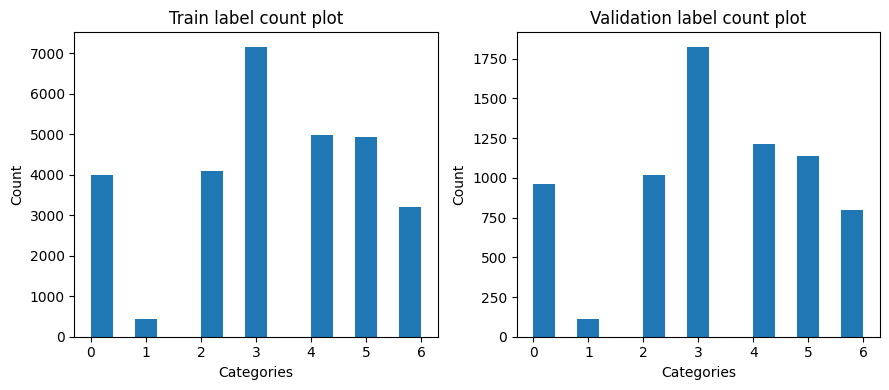

In [15]:
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.hist(train_shuffled_labels, bins=15)
plt.title("Train label count plot")
plt.xlabel("Categories")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(val_shuffled_labels, bins=15)
plt.title("Validation label count plot")
plt.xlabel("Categories")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [16]:
train_counts = np.unique(train_shuffled_labels, return_counts=True)
val_counts = np.unique(val_shuffled_labels, return_counts=True)

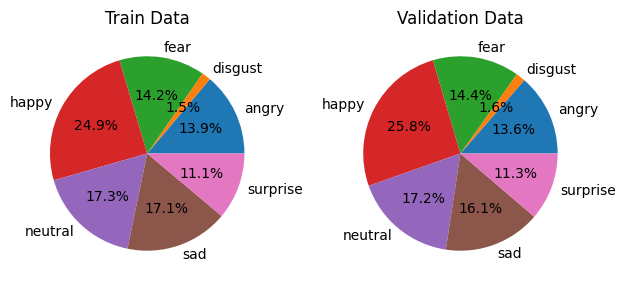

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].pie(train_counts[1], labels=categories, autopct='%1.1f%%')
ax[0].set_title('Train Data')

ax[1].pie(val_counts[1], labels=categories, autopct='%1.1f%%')
ax[1].set_title('Validation Data')

plt.tight_layout()
plt.show()

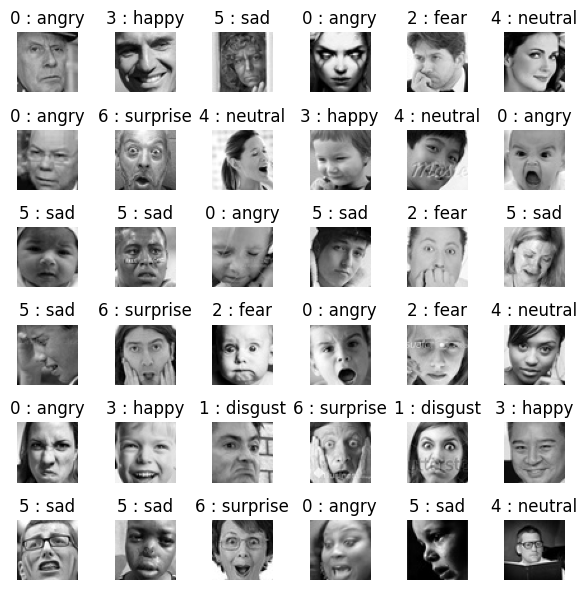

In [18]:
plt.figure(figsize=(6,6))
plot_images(train_shuffled_images, train_shuffled_labels)

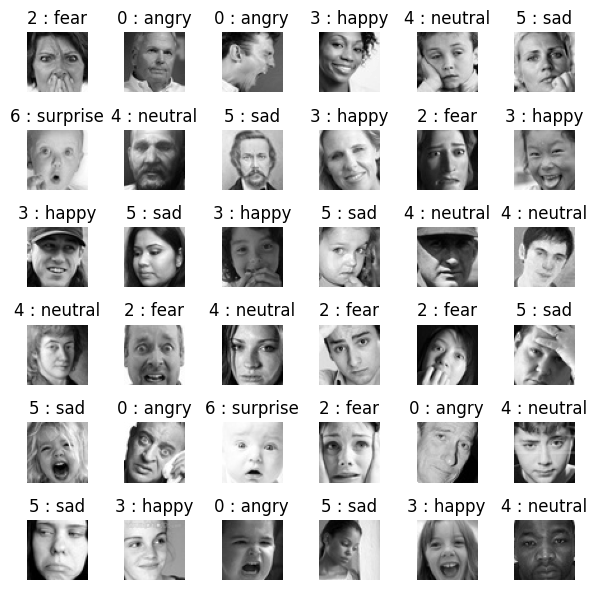

In [19]:
plt.figure(figsize=(6,6))
plot_images(val_shuffled_images, val_shuffled_labels)

In [20]:
class_counts = count_elements(train_shuffled_labels)
class_weights = {class_label: 1.0 / count for class_label, count in class_counts.items()}

v_class_counts = count_elements(val_shuffled_labels)
v_class_weights = {class_label: 1.0 / count for class_label, count in class_counts.items()}

In [21]:
print(f"Train class counts : {class_counts} \nValidation class counts : {v_class_counts}")

print(f"\n\nTrain class weights : {class_weights} \n\nValidation class weights : {v_class_weights}")

Train class counts : {0: 3993, 1: 436, 2: 4103, 3: 7164, 4: 4982, 5: 4938, 6: 3205} 
Validation class counts : {0: 960, 1: 111, 2: 1018, 3: 1825, 4: 1216, 5: 1139, 6: 797}


Train class weights : {0: 0.00025043826696719256, 1: 0.0022935779816513763, 2: 0.00024372410431391665, 3: 0.00013958682300390843, 4: 0.0002007226013649137, 5: 0.0002025111381125962, 6: 0.00031201248049921997} 

Validation class weights : {0: 0.00025043826696719256, 1: 0.0022935779816513763, 2: 0.00024372410431391665, 3: 0.00013958682300390843, 4: 0.0002007226013649137, 5: 0.0002025111381125962, 6: 0.00031201248049921997}


In [22]:
num_classes = len(categories)

x_train = np.expand_dims(train_shuffled_images, axis=-1)
x_val = np.expand_dims(val_shuffled_images, axis=-1)

x_train.shape, x_val.shape

((28821, 48, 48, 1), (7066, 48, 48, 1))

In [23]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,         
    rotation_range=20,         
    width_shift_range=0.1,     
    height_shift_range=0.1,   
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=True,      
    fill_mode='nearest',  
)

batch_size = 128
train_generator = datagen.flow_from_directory(
    os.path.join(directory, "train"),
    target_size = (48,48),
    color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

val_generator = datagen.flow_from_directory(
    os.path.join(directory, "validation"),
    target_size = (48,48),
    color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [24]:
model = keras.models.Sequential()

#1st CNN layer
model.add(keras.layers.Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(keras.layers.Dropout(0.25))

#2nd CNN layer
model.add(keras.layers.Conv2D(128,(5,5),padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(keras.layers.Dropout (0.25))

#3rd CNN layer
model.add(keras.layers.Conv2D(512,(3,3),padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(keras.layers.Dropout (0.25))

#4th CNN layer
model.add(keras.layers.Conv2D(512,(3,3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

#Fully connected 1st layer
model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.25))


# Fully connected layer 2nd layer
model.add(keras.layers.Dense(512))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 512)       2

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    x_train,
    train_shuffled_labels,
    epochs=20,
    validation_data=(x_val, val_shuffled_labels),
    class_weight=class_weights
)

Epoch 1/20
